In [ ]:
!pip install torch-geometric
!pip install open3d
# torch-scatter torch-sparse torch-cluster torch-spline-conv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.0 MB/s eta 0:00:00


In [ ]:
import random
import time
import open3d as o3d
import numpy as np
import gc
import os
import random


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.loader import DataLoader


import torch
from torch.utils.data import Dataset
from torch_geometric.datasets import ModelNet
from torch_geometric.transforms import SamplePoints, NormalizeScale
from torch_geometric.data import Data
import torch_geometric.transforms as T

from google.colab import drive
from google.colab import files


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/ADLG/Project_2/ModelNet10'


## Task 2.1 Voxel Format

In [49]:

your_desired_seed = 32  # Example seed
torch.manual_seed(your_desired_seed)
np.random.seed(your_desired_seed)
random.seed(your_desired_seed)


pre_transform = T.NormalizeScale()
# It's the transform applied to the data object before being saved to the disk.
# Centers and normalizes node positions in the 3D mesh to the interval (−1,1)(-1, 1)(−1,1)

train_dataset = ModelNet(
    root=root_path, name='10', train=True,
    #transform=transform_voxel,
    pre_transform=pre_transform
)
test_dataset = ModelNet(
    root=root_path, name='10', train=False,
    #transform=transform_voxel,
    pre_transform=pre_transform
)

batch_size = 36

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=8)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


When dealing with 3D data, such as point clouds or meshes, normalization is  often done to ensure that the scale of the objects is consistent across the dataset. This is important for models that are sensitive to the scale and position of the objects, as it makes the model training more stable and allows the model to learn scale-invariant features.

Normalization in machine learning is a vital preprocessing step that enhances model performance by ensuring uniform feature scaling. It speeds up convergence in algorithms like gradient descent, prevents numerical instabilities by reducing scale disparities, and ensures no single feature disproportionately influences the model due to its size. Additionally, normalization is crucial for models that rely on distance calculations and helps stabilize neural network training by reducing internal covariate shift. It also improves model generalization, acting as a form of regularization. This makes normalization an essential practice for effective and balanced machine learning models.

In [ ]:
num_classes_train = train_dataset.num_classes
class_distribution_train = np.zeros(num_classes_train, dtype=int)

for data in train_dataset:
    class_distribution_train[data.y.item()] += 1

# Data exploration train
print("train_dataset: Total number of samples:", len(train_dataset))
print("train_dataset: Number of classes:", num_classes_train)
print("train_dataset: Class distribution:", class_distribution_train)


num_classes_test = test_dataset.num_classes
class_distribution_test = np.zeros(num_classes_test, dtype=int)

for data in test_dataset:
    class_distribution_test[data.y.item()] += 1

# Data exploration train
print("val_dataset: Total number of samples:", len(test_dataset))
print("val_dataset: Number of classes :", num_classes_test)
print("val_dataset: Class distribution:", class_distribution_test)


def check_missing_data(dataset):
    missing_data_count = 0
    invalid_data_count = 0

    for data in dataset:
        if data.pos is None or len(data.pos) == 0:
            missing_data_count += 1
            continue

        if torch.isnan(data.pos).any():
            invalid_data_count += 1

    return missing_data_count, invalid_data_count

train_missing, train_invalid = check_missing_data(train_dataset)
print(f"Training Dataset: Missing data samples: {train_missing}, Invalid data samples: {train_invalid}")

test_missing, test_invalid = check_missing_data(test_dataset)
print(f"Validation Dataset: Missing data samples: {test_missing}, Invalid data samples: {test_invalid}")

train_dataset: Total number of samples: 3991
train_dataset: Number of classes: 10
train_dataset: Class distribution: [106 515 889 200 200 465 200 680 392 344]
val_dataset: Total number of samples: 908
val_dataset: Number of classes : 10
val_dataset: Class distribution: [ 50 100 100  86  86 100  86 100 100 100]
Training Dataset: Missing data samples: 0, Invalid data samples: 0
Validation Dataset: Missing data samples: 0, Invalid data samples: 0


### Random Baseline

We need model that makes random predictions for each data sample and then assesses the accuracy of these predictions. The purpose of a random baseline is to set a minimal performance benchmark. Meaningful model should perform better.

In [ ]:
def random_baseline_accuracy(dataset):
    correct = 0
    total = len(dataset)

    for data in dataset:
        # Generate a random class prediction
        random_pred = torch.randint(0, dataset.num_classes, (1,))

        # Check if the prediction is correct
        correct += int(random_pred.item() == data.y.item())

    accuracy = correct / total
    return accuracy

train_accuracy = random_baseline_accuracy(train_dataset)
print(f"Random Baseline Accuracy on Training Data: {train_accuracy:.2f}")

test_accuracy = random_baseline_accuracy(test_dataset)
print(f"Random Baseline Accuracy on Validation Data: {test_accuracy:.2f}")


Random Baseline Accuracy on Training Data: 0.10
Random Baseline Accuracy on Validation Data: 0.11


# Voxelization

### CNN

In [55]:


def voxelization_transform():
    def transform(mesh):
        o3d_mesh = o3d.geometry.TriangleMesh(
            vertices=o3d.utility.Vector3dVector(mesh.pos.numpy()),
            triangles=o3d.utility.Vector3iVector(mesh.face.t().contiguous().numpy())
        )
        voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(o3d_mesh, voxel_size)
        voxel_points = np.asarray([voxel.grid_index for voxel in voxel_grid.get_voxels()])
        return Data(pos=torch.tensor(voxel_points, dtype=torch.float), y=mesh.y)
    return transform


voxel_size = 0.05
# voxel_size = 0.01

pre_transform = T.NormalizeScale()
voxel_transform = voxelization_transform()

train_dataset_voxelixed = ModelNet(root=root_path, name='10', train=True, pre_transform=pre_transform, transform=voxel_transform)
test_dataset_voxelized = ModelNet(root=root_path, name='10', train=False, pre_transform=pre_transform, transform=voxel_transform)

# Randomly split the dataset into training and validation

from torch.utils.data import random_split
val_size = int(0.2 * len(train_dataset_voxelixed))
train_size = len(train_dataset_voxelixed) - val_size

train_dataset_voxelixed, val_dataset_voxelized = random_split(train_dataset_voxelixed, [train_size, val_size])



In [56]:
class VoxelGridToTensorDataset(Dataset):
    def __init__(self, modelnet_voxelized_dataset, grid_size):
        self.dataset = modelnet_voxelized_dataset
        self.grid_size = grid_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]

        # Convert voxel points to 3D grid tensor
        grid_tensor = self.voxel_points_to_3d_grid_tensor(data.pos, self.grid_size)

        return grid_tensor, data.y

    def voxel_points_to_3d_grid_tensor(self, voxel_points, grid_size):
        grid_tensor = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
        for point in voxel_points:
            x, y, z = point.long()
            if 0 <= x < grid_size and 0 <= y < grid_size and 0 <= z < grid_size:
                grid_tensor[x, y, z] = 1
        return torch.tensor(grid_tensor).unsqueeze(0)  # Add channel dimension


grid_size = 32
batch_size = 128



train_dataset_tensor = VoxelGridToTensorDataset(train_dataset_voxelixed, grid_size)
val_dataset_tensor = VoxelGridToTensorDataset(val_dataset_voxelized, grid_size)
test_dataset_tensor = VoxelGridToTensorDataset(test_dataset_voxelized, grid_size)



def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


train_loader = DataLoader(train_dataset_tensor, batch_size, shuffle=False, num_workers=8, worker_init_fn=seed_worker)
val_loader = DataLoader(val_dataset_tensor, batch_size, shuffle=False, num_workers=8, worker_init_fn=seed_worker)
test_loader = DataLoader(test_dataset_tensor, batch_size, shuffle=False, num_workers=8, worker_init_fn=seed_worker)

print(train_dataset_tensor[0][0].shape) # the voxel grid tensor and the label (y)




Data(y=[1], pos=[1236, 3])
torch.Size([1, 32, 32, 32])


torch.Size([1, 32, 32, 32])


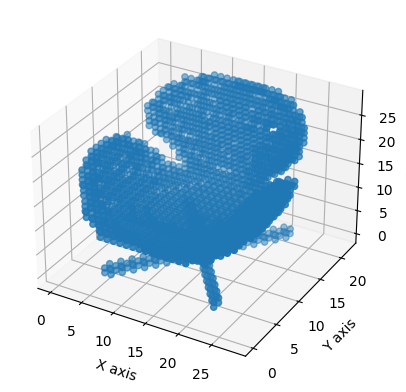

In [106]:

def visualize_voxel_grid(voxel_grid_tensor):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Remove channel dimension and convert to NumPy
    voxel_grid_np = voxel_grid_tensor.squeeze(0).numpy()

    # Extract the points where the voxel is 1 (occupied)
    x, y, z = np.nonzero(voxel_grid_np)

    # Plot these points as scatter
    ax.scatter(x, y, z, marker='o')

    # Setting labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    # ax.set_title('3D Voxelized Data Visualization')

    plt.show()

# Get the first sample (voxel grid tensor) from the dataset
voxel_grid_tensor, _ = train_dataset_tensor[231]

print(voxel_grid_tensor.shape)

visualize_voxel_grid(voxel_grid_tensor)


In [ ]:


# class Simple3DCNN(nn.Module):
#     def __init__(self):
#         super(Simple3DCNN, self).__init__()

#         self.conv1 = nn.Conv3d(1, 8, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv3d(8, 16, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool3d(2)
#         # max pooling layer with a window size of 2x2x2

#         self.fc1 = nn.Linear(32 * 4 * 4 * 4, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, 10)  # 10 classes


#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         # print('dimension befor flatten', x.shape)
#         x = x.view(-1, 32 * 4 * 4 * 4)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


In [ ]:
class Smaller3DCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(Smaller3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 4, kernel_size=3, padding=1)  # 4 filters
        self.pool = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(4, 4, kernel_size=3, padding=1)  # Reduced to 4 filters


        self.fc1 = nn.Linear(4 * 8 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Dynamically determine the correct number of elements for the first FC layer
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:

# Initialize
model = Smaller3DCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=3, patience=3):
    best_val_loss = np.Inf
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0

        # with 128 batchsize, get trainloader of 25
        for input, target in train_loader:
            target = target.squeeze()
            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()



        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for input, target in val_loader:
                target = target.squeeze()
                output = model(input)
                loss = criterion(output, target)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping triggered")
                break

# Train and validate the model
train_and_validate(model, train_loader, val_loader, criterion, optimizer)


KeyboardInterrupt: ignored

In [ ]:
def evaluate_on_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            target = target.squeeze()
            loss = criterion(output, target)
            total_loss += loss.item()

            _, predictions = torch.max(output, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = (np.array(all_predictions) == np.array(all_targets)).mean()
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    return all_predictions, all_targets

# Evaluate the model and get predictions and true labels
predictions, targets = evaluate_on_test(model, test_loader, criterion)

# Create the confusion matrix
cm = confusion_matrix(targets, predictions)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
